# 数据导入

In [20]:
from datasets import load_dataset

dataset = load_dataset(path="imagefolder", data_dir="E:/jupyter/VIT_example/dataset/hfdataset_Mini") #路径不能有中文

Resolving data files:   0%|          | 0/5380 [00:00<?, ?it/s]

In [24]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3766
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1614
    })
})


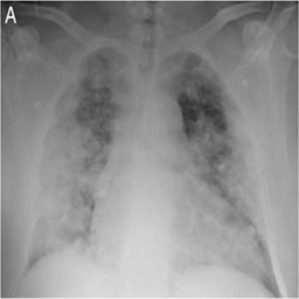

In [26]:
dataset["train"][0]["image"]

In [23]:
dataset = dataset["train"].train_test_split(test_size=0.3)#随机划分30%数据做验证集

In [25]:
dataset = dataset.shuffle(seed= 42)#打乱数据集

# 利用VIT训练模型

### 将图像转换为张量

In [27]:

from transformers import AutoImageProcessor

# 加载图像处理器
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

def transforms(examples):
    images = [img.convert("RGB").resize((224, 224)) for img in examples["image"]]  # 图片被转换为RGB通道，同时缩放至224*224
    
    examples["pixel_values"] = image_processor(images, return_tensors="pt")["pixel_values"] # 使用image_processor处理图像，生成pixel_values（张量图像）
    return examples

dataset.set_transform(transforms)
dataset['train'][0].keys()

dict_keys(['image', 'label', 'pixel_values'])

### 定义数据整理器，用于对图像分批

In [31]:
import torch

def collate_fn(batch): # batch应包含pixel_values和labels
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]), # 返回分批的的图像（张量）
        'labels': torch.tensor([x['labels'] for x in batch]) # 返回分批的的标签（张量）
    }

### 定义评价器

In [30]:
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(p):
    # 计算预测结果
    predictions = np.argmax(p.predictions, axis=1)

    # 计算各个指标
    accuracy = accuracy_metric.compute(predictions=predictions, references=p.label_ids)
    f1 = f1_metric.compute(predictions=predictions, references=p.label_ids, average='weighted')
    precision = precision_metric.compute(predictions=predictions, references=p.label_ids, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=p.label_ids, average='weighted')

    # 输出结果
    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }


Using the latest cached version of the module from C:\Users\w1586\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Apr 26 15:30:14 2024) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.


### 修改label为labels以符合VIT要求

In [29]:
for split in dataset:
    dataset[split] = dataset[split].rename_column('label', 'labels') # 将 'label' 特征名改为 'labels'

### 加载初始模型

In [32]:
from transformers import ViTForImageClassification

model_name = 'google/vit-base-patch16-224-in21k' # 指定VIT模型

labels = dataset['train'].features['labels'].names # 提取标签信息

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels), # 指定模型输出层的大小(类别数)
    id2label={str(i): c for i, c in enumerate(labels)}, #建立标签和类别索引的映射关系
    label2id={c: str(i) for i, c in enumerate(labels)}
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 设定训练参数

In [33]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-simple-covid", # 模型保存的目录
  per_device_train_batch_size=16, # 越大模型越稳定但需要消耗更大显存
  evaluation_strategy="steps", #模型评估策略，steps表示每过一定次数评估一次模型
  num_train_epochs=100, #训练轮数
  fp16=True, #半精度浮点，可减少内存占用，需要设备支持
  save_steps=100, #多少步保存一次模型
  eval_steps=100, #多少步评估一次模型
  logging_steps=3, #多少步评估一次日志
  learning_rate=2e-4, #学习率 越低越容易过拟合，越高收敛越慢
  save_total_limit=3, #保存的模型总数
  remove_unused_columns=False, #删除未使用列，减少内存消耗
  push_to_hub=False, #是否将模型发布到hf社区
  report_to='tensorboard', #日志的报告地
  load_best_model_at_end=True, #是否自动加载最优模型
  ignore_data_skip=True #从断点继续训练模型
)


##### 更多参数解释 https://zhuanlan.zhihu.com/p/363670628

### 将参数传入训练器

In [9]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    #optimizers 优化器 默认为AdamW
    
)


### 训练开始

In [ ]:
# # 启动 TensorBoard
# %tensorboard --logdir 'E:\jupyter\VIT_example\vit-simple-covid\runs'

In [10]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()


C:\Users\w1586\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.595500,0.431667,0.852357,0.851729,0.856298,0.852357
200,0.302400,0.305389,0.890819,0.892462,0.905706,0.890819
300,0.198800,0.253281,0.913772,0.913701,0.915644,0.913772
400,0.365600,0.395022,0.884615,0.882018,0.893849,0.884615
500,0.046400,0.316007,0.908809,0.908062,0.909079,0.908809
600,0.139200,0.837372,0.794665,0.780912,0.841595,0.794665
700,0.111600,0.285141,0.915633,0.914881,0.916052,0.915633
800,0.415300,0.318731,0.924318,0.923220,0.925254,0.924318
900,0.201000,0.294239,0.915633,0.915658,0.924413,0.915633
1000,0.053100,0.278565,0.929901,0.929564,0.929784,0.929901


***** train metrics *****
  epoch                    =         100.0
  total_flos               = 27194158257GF
  train_loss               =         0.018
  train_runtime            =    2:11:55.37
  train_samples_per_second =        47.604
  train_steps_per_second   =         2.982


# 性能验证

## 基准测试

In [22]:
metrics = trainer.evaluate(dataset['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


***** eval metrics *****
  eval_accuracy           =     0.9646
  eval_f1                 =     0.9766
  eval_loss               =     0.2533
  eval_precision          =     0.9698
  eval_recall             =     0.9835
  eval_runtime            = 0:00:15.14
  eval_samples_per_second =    106.437
  eval_steps_per_second   =     13.338


## 外部验证

In [23]:
from datasets import load_dataset

Outerdataset = load_dataset(path="imagefolder", data_dir="E:/jupyter/VIT_example/dataset/Outerdataset") #路径不能有中文

Resolving data files:   0%|          | 0/312 [00:00<?, ?it/s]

In [24]:
Outerdataset.set_transform(transforms)
Outerdataset['test'][0].keys()

dict_keys(['image', 'label', 'pixel_values'])

In [25]:
for split in Outerdataset:
    Outerdataset[split] = Outerdataset[split].rename_column('label', 'labels') # 将 'label' 特征名改为 'labels'

In [26]:
metrics = trainer.evaluate(Outerdataset["test"])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  eval_accuracy           =     0.9038
  eval_f1                 =     0.9215
  eval_loss               =     2.8943
  eval_precision          =     0.8713
  eval_recall             =     0.9778
  eval_runtime            = 0:00:11.75
  eval_samples_per_second =     26.545
  eval_steps_per_second   =      3.318


## 对特定图片进行预测

In [27]:
num=1
image=Outerdataset["test"][num]["image"]
Outerdataset["test"][num]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1458x1303>,
 'labels': 0,
 'pixel_values': tensor([[[-0.6235, -0.6157, -0.6078,  ..., -0.9843, -0.9843, -0.9843],
          [-0.5843, -0.5765, -0.5686,  ..., -0.9843, -0.9843, -0.9843],
          [-0.5608, -0.5686, -0.5608,  ..., -0.9843, -0.9843, -0.9843],
          ...,
          [-0.1059, -0.0824, -0.0431,  ..., -0.3333, -0.3647, -0.3804],
          [-0.1137, -0.0824, -0.0353,  ..., -0.3412, -0.3647, -0.3882],
          [-0.1137, -0.0824, -0.0353,  ..., -0.3490, -0.3725, -0.3882]],
 
         [[-0.6235, -0.6157, -0.6078,  ..., -0.9843, -0.9843, -0.9843],
          [-0.5843, -0.5765, -0.5686,  ..., -0.9843, -0.9843, -0.9843],
          [-0.5608, -0.5686, -0.5608,  ..., -0.9843, -0.9843, -0.9843],
          ...,
          [-0.1059, -0.0824, -0.0431,  ..., -0.3333, -0.3647, -0.3804],
          [-0.1137, -0.0824, -0.0353,  ..., -0.3412, -0.3647, -0.3882],
          [-0.1137, -0.0824, -0.0353,  ..., -0.3490, -0.3725, -0.3882

In [28]:
from transformers import pipeline

classifier = pipeline("image-classification", model='./vit-simple-covid/' )
classifier(image)

[{'score': 0.9770867228507996, 'label': 'Covid'},
 {'score': 0.01040149386972189, 'label': 'Normal'},
 {'score': 0.007127898279577494, 'label': 'Viral Pneumonia'},
 {'score': 0.005383974872529507, 'label': 'Lung Opacity'}]

## 进行Covid与非Covid的二分类预测

In [29]:
def compute_metrics(p):
    # 将预测结果中的所有非0（非Covid）标签转换为1
    predictions = np.argmax(p.predictions, axis=1)
    binary_predictions = np.where(predictions == 0, 0, 1)

    # 将真实标签中的所有非0（非Covid）标签转换为1
    binary_references = np.where(p.label_ids == 0, 0, 1)

    # 计算二分类的各个指标
    accuracy = accuracy_metric.compute(predictions=binary_predictions, references=binary_references)['accuracy']
    f1 = f1_metric.compute(predictions=binary_predictions, references=binary_references, average='binary')['f1']
    precision = precision_metric.compute(predictions=binary_predictions, references=binary_references, average='binary')['precision']
    recall = recall_metric.compute(predictions=binary_predictions, references=binary_references, average='binary')['recall']

    # 返回计算的指标
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [30]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-simple-covid", # 模型保存的目录
  per_device_train_batch_size=16, # 越大模型越稳定但需要消耗更大显存
  evaluation_strategy="steps", #模型评估策略，steps表示每过一定次数评估一次模型
  num_train_epochs=100, #训练轮数
  fp16=True, #半精度浮点，可减少内存占用，需要设备支持
  save_steps=100, #多少步保存一次模型
  eval_steps=100, #多少步评估一次模型
  logging_steps=3, #多少步评估一次日志
  learning_rate=2e-4, #学习率 越低越容易过拟合，越高收敛越慢
  save_total_limit=10, #保存的模型总数
  remove_unused_columns=False, #删除未使用列，减少内存消耗
  push_to_hub=False, #是否将模型发布到hf社区
  report_to='tensorboard', #日志的报告地
  load_best_model_at_end=True, #是否自动加载最优模型
  ignore_data_skip=True #从断点继续训练模型
)
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=Outerdataset["test"],
    tokenizer=image_processor,
    
)


In [31]:
metrics = trainer.evaluate(Outerdataset['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


***** eval metrics *****
  eval_accuracy           =     0.9038
  eval_f1                 =     0.9215
  eval_loss               =     2.8943
  eval_precision          =     0.8713
  eval_recall             =     0.9778
  eval_runtime            = 0:00:11.62
  eval_samples_per_second =     26.837
  eval_steps_per_second   =      3.355
